# Import libraries

In [321]:
import numpy as np
import pandas as pd
#viz
import matplotlib.pyplot as plt
import seaborn as sns
#for text pre-processing
import re, string
import spacy
import langid

#spell-check
from textblob import TextBlob


#TF IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#for logistic regression and Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
#linguistic models
import gensim.downloader as api
#time performance
import time

# Openning the file. Performing EDA.

## Display distributions of categories for both train and test datasets

In [225]:
#load dataset
test = pd.read_csv('test.csv', delimiter=',', header = None)
train = pd.read_csv('train.csv', delimiter=',', header= None)

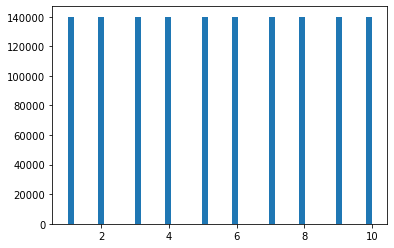

In [472]:
plt.hist(train[0], bins=50)
plt.show()

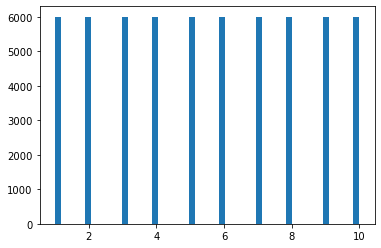

In [473]:
plt.hist(test[0], bins=50)
plt.show()

## Manipulating the datasets

Filling the NA values with empty strings. Combining the question body and title in one column – "question"

In [226]:
train.fillna('', inplace=True)
train["question"] = train[1] +' '+ train[2]

test.fillna('', inplace=True)
test["question"] = test[1] +' '+ test[2]

### How many words do questions contain?

In [478]:
train['question_len']=train["question"].apply(lambda x: len(x.split()))
test['question_len']=test["question"].apply(lambda x: len(x.split()))

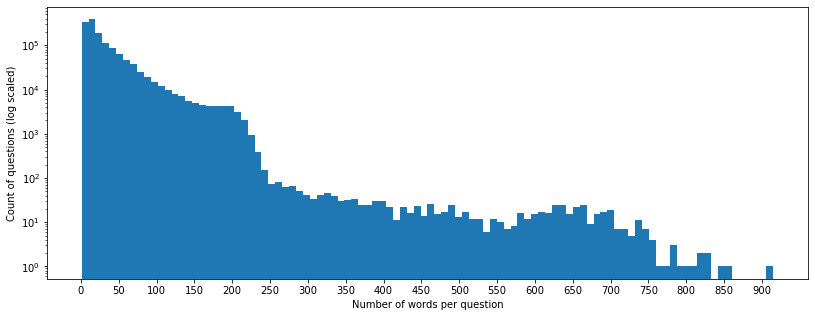

In [507]:
#lenght distribution
f = plt.figure(figsize=(30,5))
ax = f.add_subplot(121)

ax.hist(train['question_len'],bins=100)
ax.set_xlabel('Number of words per question')
ax.set_ylabel('Count of questions (log scaled)')
plt.xticks(np.arange(0, 915, 50))
plt.yscale('log')
plt.show()

In [31]:
#print the longest question in the dataset
for i in train.loc[train['question_len']>900,'question']:
    print(i)

why me why my life? hello i am a mother ofa 10 week and 3 day old son and i am abused by my husband it all started before we got married he get drunk and would tell me he use to beat his first and 2nd wife but i still married thanking it be diffrert for me but i was wrong, first it was yelling, then he would tell me he would hit me he would say stuff like i was lucky he not hit me because he could really hurt me then the grabbing started he would grab me by the arm so hard it would leaves marks he would pin me to the wall so i could not move and yellthen one day he got so drung and grabed my arm telling me he was going hit me and i told him i was not scared of him so he told me i batter be hecause he could kill me then he pushed me so hard a almost fall i finel thongh he calm down so i went to bed he would come in and yell call me names then he set on the bad and puch me so hard i fell of the bed, then i got pranget we got in to it he was so drunk he grab my arms and puch in to the doo

In [59]:
#what is the average lenth of question?
np.average(train['question_len'])

32.39525785714286

# Building the pre-processing Pipeline

## Removing the non-English questions

In [474]:
# Define a function
def lng(text):
  a = langid.classify(text)[0]
  return a

In [476]:
# Identify the language
# Estimate the proportion of non-English questions and execution time
sample_size=5000
lang_experiment = train.sample(n = sample_size, random_state = 234)

start=time.time()

lang_experiment['lang'] = lang_experiment["question"].apply(lambda x: lng(x))

# Remove non-English words
lang_experiment_en = lang_experiment.loc[lang_experiment["lang"]=='en' ]

stop=time.time()

lang_execution=stop-start
print('Running time is ',lang_execution, 'secons for 5,000 questions')
print('The proportion of non-English questions is ',(sample_size-len(lang_experiment_en))/len(lang_experiment))

Running time is  17.91603183746338 secons for 5,000 questions
The proportion of non-English questions is  0.0158


In [257]:
#what languages are present?
lang_experiment.lang.value_counts()

en    4921
fr      17
pl       8
pt       6
de       6
it       5
es       5
da       3
nl       3
ms       3
br       3
cy       2
af       2
mt       2
no       2
wa       1
ca       1
vo       1
id       1
eo       1
sv       1
sw       1
hr       1
tl       1
oc       1
fi       1
sl       1
Name: lang, dtype: int64

## Lemmatization function

In [6]:
#download the language model Spacy pipeline
nlp = spacy.load('en_core_web_sm')
def lemmatizeSentence(sentence):
    doc = nlp(sentence)
    lemma_sentence=[]
    for token in doc:
        lemma_sentence.append(token.lemma_)
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

/Users/nikigelkott/opt/anaconda3/envs/value/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Spelling correction

In [7]:
#function to correct spelling mistakes by words
def correct_word_spelling(sentence):
    raw=TextBlob(sentence)
    corrected=str(raw.correct())
    return corrected
correct_word_spelling('NLP is veery excitiing')

'NLP is very exciting'

## Combining defined functions and Regex pipeline

In [10]:
#data cleaning
def preprocess(text,lemma=False,spell=False):
    text = text.lower() #convert words to lower case
    text = text.replace(r'\n', "") #remove trailing newlines
    text = text.replace(r'(@\[A-Za-z0-9]+)|(\r)|(\t)|(<br />)', '') #remove @ and trailing whitespaces
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text) #remove URL and websites
    text = text.replace(r'([^0-9A-Za-z \t])', "") #remove regular expressions
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) #remove punctations
    text = re.sub("\'\w+", '', text) # Remove ticks and the next character
    text = re.sub(r'\w*\d+\w*', '', text) #remove numbers
    text = re.sub('\s{2,}', " ", text) # Replace the over spaces
    text = text.encode('ascii', 'ignore').decode() # Remove unicode characters
    text=re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text) #remove single letters
    if spell is True:
        text=correct_word_spelling(text)
    if lemma is True:
        text = lemmatizeSentence(text)
    return text

In [11]:
#Pipeline in action
print(train["question"][543])
print('#####')
print(preprocess(train["question"][543],lemma=True,spell=True))

who was the longest driver on the PGA tour in the 1950's? we all know Jack Nicklaus was the longest in the 60's, but I'm not sure about the 50's...and Arnold Palmer doesn't count as he was mostly a 60's player as well....thanks
#####
who be the long driver on the pa tour in the we all know jack nicklaus be the long in the but not sure about the and arnold palmer doesn count as he be mostly player as well thank 


# Developing classification pipeline

## Customizing the accuracy calculation

Downloading similarity matrix. Please refer to Similarity_matrix.ipynb.

In [375]:
df_similarities=pd.read_csv('Similarity_df.csv',index_col=0)

In [13]:
#function to calculate accuracy of prediction based on similarity matrix
def mod_accuracy(Y_pred,Y_true,df_weights):
    scores=[]
    for i,j in zip(Y_pred,Y_true):
        score=float(df_similarities[(df_weights['0'] == i-1) & (df_weights['1'] == j-1) ]['2'])
        scores.append(score)
    scores=np.array(scores)
    scores = np.where(scores ==0, 1, scores)
    return np.mean(scores)

## Helper function for assessing the performance of the classifier

In [270]:
def fit_performance(classifier,
                    X_train_tf,
                    X_test_tf,
                    train_sample,
                   df_similarities,
                    test_sample):
    fit_start=time.time()
    classifier.fit(X_train_tf, train_sample[0])
    
    print('Training finished')
    ######TIME MONITORING
    train_time=time.time()-fit_start
    
    #Training accuracy
    train_acc=classifier.score(X_train_tf,train_sample[0])
    
    #Predicting
    y_pred = classifier.predict(X_test_tf)
    
    
    #Measuring simple accuracy on the test set
    test_acc=accuracy_score(y_pred,test_sample[0])
    
    
    #Measuring custom accuracy on the test set
    
    mod_acc=mod_accuracy(y_pred,test_sample[0],df_similarities)
    
    
    return train_acc,test_acc,mod_acc,train_time

In [ ]:
test_sample_size=5000
#pre-processing
train["clean_text"]=train["question"].apply(lambda x: preprocess(x))
#remove empty questions
train_cleaned=train[train['clean_text'].apply(lambda x: len(x.split()) > 0)]
# same procedure for test set
train_sample_size=100000
train_sample = train_cleaned.sample(n = train_sample_size, random_state = 234)

test_sample = test.sample(n = test_sample_size, random_state = 234)
test_sample["clean_text"]=test_sample["question"].apply(lambda x: preprocess(x))
test_sample=test_sample[test_sample['clean_text'].apply(lambda x: len(x.split()) > 0)]
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(train_sample["clean_text"])
X_test_tf = tf_idf.transform(test_sample["clean_text"])

train_vs_test_acc=[]
for pen in [0.1,0.5,1,5,10]:
    for type_ in ['l2',
                 #'l1'
                 ]:
        log_performance=fit_performance(LogisticRegression(multi_class='multinomial',
                                                           solver='lbfgs',
                                  #solver='saga',
                                  C=pen, penalty = type_, 
                                  max_iter = 20000),
                                  X_train_tf,
                                X_test_tf,
                                  train_sample,
                                  df_similarities,
                                  test_sample)
        train_vs_test_acc.append([type_,pen,log_performance[0],log_performance[1]])

In [318]:
results_tuning=pd.DataFrame(train_vs_test_acc,columns =['Type_of_Regularization',
                                                       'Penalty_term',
                                                       'Training_accuracy',
                                                       'Testing_accuracy'])
results_tuning

,Type_of_Regularization,Penalty_term,Training_accuracy,Testing_accuracy
0,l2,0.1,0.6058,0.517607
1,l2,0.5,0.7483,0.566026
2,l2,1.0,0.8238,0.583633
3,l2,5.0,0.9629,0.584634
4,l2,10.0,0.9871,0.576831


## Logistic Regression optimization via dimensionality reduction

### Comparing SVD and vocabulary limitation for the classification with different parameters

In [ ]:
test_sample_size=5000
#lists to store results
max_features_stats=[]
svd_stats=[]

#training sizes range (picked by a rule of thumb)
for i in [1000,10000,100000]:
    train_sample_size=i
    train_sample = train_cleaned.sample(n = train_sample_size, random_state = 234)
    ################### NO DIMENSIONALITY REDUCTION
    tf_idf = TfidfVectorizer()
    X_train_tf_full = tf_idf.fit_transform(train_sample["clean_text"])
    dim=X_train_tf_full.shape[1]
    X_test_tf_full = tf_idf.transform(test_sample["clean_text"])
    log_performance_full=fit_performance(LogisticRegression(multi_class='multinomial',
                                  solver='lbfgs',
                                  C=10, penalty = 'l2', 
                                  max_iter = 20000),
                                  X_train_tf_full,
                                X_test_tf_full,
                                  train_sample,
                                  df_similarities,
                                  test_sample)

    ################### VOCABULARY LIMIT DIMENSIONALITY REDUCTION
    #max_features range (picked by a rule of thumb)
    for k in [100,500,1000,5000]:
        tf_idf = TfidfVectorizer(max_features=k)
        X_train_tf = tf_idf.fit_transform(train_sample["clean_text"])
        X_test_tf = tf_idf.transform(test_sample["clean_text"])
                                                                                
        log_performance=fit_performance(LogisticRegression(multi_class='multinomial',
                                  solver='lbfgs',
                                  C=10, penalty = 'l2', 
                                  max_iter = 20000),
                                  X_train_tf,
                                X_test_tf,
                                  train_sample,
                                  df_similarities,
                                  test_sample)
                                                                               
        max_features_stats.append([log_performance_full,#performance of the large model
                                   log_performance[3],  #train_time
                                   i,                   #train_size
                                   k,                   #max_features
                                   log_performance[2]]) #mod accuracy
    #print('max_features_stats')
    #print(max_features_stats)
    ################### SVD DIMENSIONALITY REDUCTION
    #n_components range (picked by a rule of thumb)
    for r in [100,500,1000]:
        time_reduction=time.time()
        svd = TruncatedSVD(n_components=r, random_state=42)
        train_reduced=svd.fit_transform(X_train_tf_full)
        time_reduction=time.time()-time_reduction #duration of dim reduction for training set
        print(time_reduction)
        test_reduced=svd.transform(X_test_tf_full)
        log_performance=fit_performance(LogisticRegression(multi_class='multinomial',
                                  solver='lbfgs',
                                  C=10, penalty = 'l2', 
                                  max_iter = 20000),
                                  train_reduced,
                                test_reduced,
                                  train_sample,
                                  df_similarities,
                                  test_sample)
        time_train=log_performance[3]+time_reduction
        print(log_performance[3])
        #print(svd.explained_variance_ratio_.sum())
        #print('#########log_performance_svd is ',time_train,i,r,log_performance)
        svd_stats.append([log_performance_full,dim,time_train,i,r,log_performance[2]])
    #print('svd_stats')
    #print(svd_stats)

### Results visualization

In [275]:
cols=['train_size',
      'method',
      'dimension',
      'reduced_dim',
      'model_acc',
      'model_time']

In [276]:
DR_results_svd=pd.DataFrame(columns=cols)
full_results=pd.DataFrame(columns=['train_size',
      'method',
      'dimension',
      'model_acc',
      'model_time'])
DR_results_mf=pd.DataFrame(columns= ['method',
      'reduced_dim',
      'model_acc',
      'model_time'])

In [277]:
train_size=[i[3] for i in svd_stats ]
dimension=[i[1] for i in svd_stats ]
model_acc=[i[5] for i in svd_stats ]
model_time=[i[2] for i in svd_stats ]
reduced_dim=[i[4] for i in svd_stats ]
DR_results_svd['train_size']=train_size
DR_results_svd['dimension']=dimension
DR_results_svd['model_acc']=model_acc
DR_results_svd['model_time']=model_time
DR_results_svd['reduced_dim']=reduced_dim
DR_results_svd['method']='SVD'

train_size=[i[2] for i in max_features_stats ]
model_acc=[i[4] for i in max_features_stats ]
model_time=[i[1] for i in max_features_stats ]
reduced_dim=[i[3] for i in max_features_stats ]
DR_results_mf['train_size']=train_size
DR_results_mf['model_acc']=model_acc
DR_results_mf['model_time']=model_time
DR_results_mf['reduced_dim']=reduced_dim
DR_results_mf['method']='max_features'

train_size=[i[2] for i in max_features_stats ]
train_size.extend([i[3] for i in svd_stats ])
model_acc=[i[0][2] for i in max_features_stats ]
model_acc.extend([i[0][2] for i in svd_stats ])
model_time=[i[0][3] for i in max_features_stats ]
model_time.extend([i[0][3] for i in svd_stats ])

dimension=[[i]*4 for i in [5376,21877,83180]  ]
dimension2=[[i]*3 for i in [5376,21877,83180]  ]
dimension.extend(dimension2)
out = []
for sublist in dimension:
    out.extend(sublist)

full_results['train_size']=train_size
full_results['model_acc']=model_acc
full_results['model_time']=model_time
full_results['dimension']=out

full_results['method']='full_features'

In [281]:
DR_results_svd

,train_size,method,dimension,reduced_dim,model_acc,model_time
0,1000,SVD,5376,100,0.401787,0.588181
1,1000,SVD,5376,500,0.474551,2.717817
2,1000,SVD,5376,1000,0.490636,7.011820
3,10000,SVD,21877,100,0.502446,3.629432
4,10000,SVD,21877,500,0.586359,21.886729
5,10000,SVD,21877,1000,0.602314,65.104183
6,100000,SVD,83180,100,0.532952,49.156057
7,100000,SVD,83180,500,0.641980,287.629889
8,100000,SVD,83180,1000,0.667520,638.017513


In [284]:
DR_results_mf

,method,reduced_dim,model_acc,model_time,train_size
0,max_features,100,0.267146,0.169139,1000
1,max_features,500,0.379455,0.308537,1000
2,max_features,1000,0.427773,0.347864,1000
3,max_features,5000,0.490067,1.123761,1000
4,max_features,100,0.327765,1.526420,10000
5,max_features,500,0.486812,2.726712,10000
6,max_features,1000,0.538095,4.569572,10000
7,max_features,5000,0.596103,6.607484,10000
8,max_features,100,0.343622,14.228024,100000
9,max_features,500,0.540179,48.557874,100000


In [286]:
full_results=full_results.drop_duplicates(keep='first')

In [287]:
full_results

,train_size,method,dimension,model_acc,model_time
0,1000,full_features,5376,0.490636,10.257880
4,10000,full_features,21877,0.623073,15.016202
8,100000,full_features,83180,0.701160,262.399051


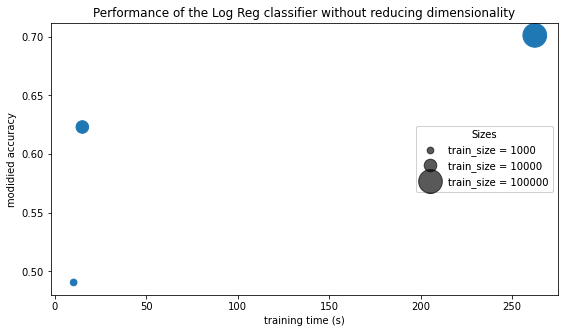

In [288]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
scatter=ax.scatter(full_results.model_time,
           full_results.model_acc,
          s=(full_results.train_size)**0.55,
          cmap='tab20')
ax.title.set_text('Performance of the Log Reg classifier without reducing dimensionality')
ax.set_xlabel('training time (s)')
ax.set_ylabel('modidied accuracy')


handles, labels = scatter.legend_elements(prop='sizes', alpha=0.6)
legend = ax.legend(handles, ['train_size = 1000','train_size = 10000','train_size = 100000'], loc="right", title="Sizes")
ax.add_artist(legend)
plt.show()

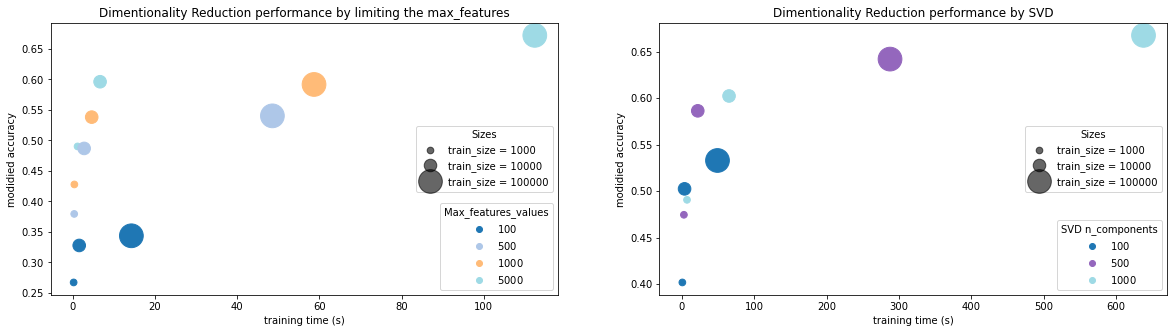

In [289]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
scatter=ax.scatter(DR_results_mf.model_time,
           DR_results_mf.model_acc,
          s=(DR_results_mf.train_size)**0.55,
           c=DR_results_mf.reduced_dim,
          cmap='tab20')
ax.title.set_text('Dimentionality Reduction performance by limiting the max_features')
ax.set_xlabel('training time (s)')
ax.set_ylabel('modidied accuracy')

legend1 = ax.legend(*scatter.legend_elements(), title="Max_features_values")

ax.add_artist(legend1)
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.6)

legend2 = ax.legend(handles, ['train_size = 1000','train_size = 10000','train_size = 100000'], loc="right", title="Sizes")

plt.ylabel('Mod_accuracy')
#ax.title.set_text('Model Accuracy for different train sizes')
#ax.set_xticks(DR_results_mf.train_size.values) 
#ax.set_xticklabels(DR_results_mf.train_size.values)
scatter1=ax2.scatter(DR_results_svd.model_time,
           DR_results_svd.model_acc,
          s=(DR_results_svd.train_size)**0.55,
           c=DR_results_svd.reduced_dim,
          cmap='tab20')
legend3 = ax2.legend(*scatter1.legend_elements(), title="SVD n_components")

ax2.add_artist(legend3)
handles2, labels2 = scatter.legend_elements(prop='sizes', alpha=0.6)
legend4 = ax2.legend(handles2, ['train_size = 1000','train_size = 10000','train_size = 100000'], loc="right", title="Sizes")
ax2.title.set_text('Dimentionality Reduction performance by SVD')
ax2.set_xlabel('training time (s)')
ax2.set_ylabel('modidied accuracy')
plt.show()

## Assessing Naive Bayes classifier

Is it possible to reduce the training time of Naive Bayes classifier by reducing the dimensionality?

In [243]:
# same procedure for test set
test_sample = test.sample(n = test_sample_size, random_state = 234)
test_sample["clean_text"]=test_sample["question"].apply(lambda x: preprocess(x))
test_sample=test_sample[test_sample['clean_text'].apply(lambda x: len(x.split()) > 0)]

#lists to store results
max_features_stats=[]

#training sizes range (picked by a rule of thumb)
for i in [1000,10000,100000]:
    train_sample_size=i
    train_sample = train_cleaned.sample(n = train_sample_size, random_state = 234)
    ################### NO DIMENSIONALITY REDUCTION
    ################### VOCABULARY LIMIT DIMENSIONALITY REDUCTION
    #max_features range (picked by a rule of thumb)
    for k in [100,1000,10000,100000]:
        tf_idf = TfidfVectorizer(max_features=k)
        X_train_tf = tf_idf.fit_transform(train_sample["clean_text"])
        X_test_tf = tf_idf.transform(test_sample["clean_text"])
        log_performance=fit_performance(MultinomialNB(),
                                  X_train_tf,
                                X_test_tf,
                                  train_sample,
                                  df_similarities,
                                  test_sample)
        max_features_stats.append([i, #train size
                                   k, #max_features
                                   log_performance[2],#mod acc
                                  log_performance[3]]) #time

Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished
Training finished


In [244]:
df_bayes=pd.DataFrame(max_features_stats,columns=['Train_size', 'max_features','mod_acc','Time'])

In [245]:
df_bayes

,Train_size,max_features,mod_acc,Time
0,1000,100,0.285589,4.031584
1,1000,1000,0.448697,3.750131
2,1000,10000,0.402516,3.804764
3,1000,100000,0.402516,4.140498
4,10000,100,0.305441,4.641404
5,10000,1000,0.565914,4.065534
6,10000,10000,0.601539,3.885395
7,10000,100000,0.570879,4.016715
8,100000,100,0.319140,4.092558
9,100000,1000,0.581309,3.974872


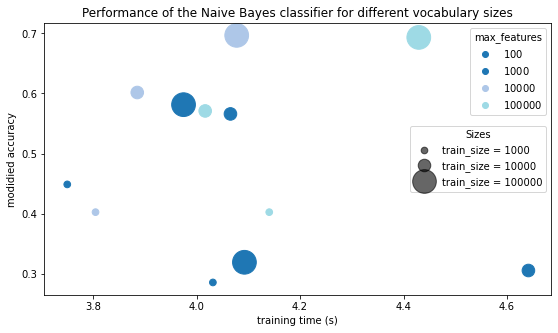

In [253]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
scatter=ax.scatter(df_bayes.Time,
           df_bayes.mod_acc,
          s=(df_bayes.Train_size)**0.55,
            c=df_bayes.max_features,
          cmap='tab20')
ax.title.set_text('Performance of the Naive Bayes classifier for different vocabulary sizes')
ax.set_xlabel('training time (s)')
ax.set_ylabel('modidied accuracy')


legend1 = ax.legend(*scatter.legend_elements(), title="max_features")

ax.add_artist(legend1)
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.6)

legend2 = ax.legend(handles, ['train_size = 1000','train_size = 10000','train_size = 100000'], loc="right", title="Sizes")
plt.show()

## Putting together the pre-processing, TF-IDF vectorization and custom accuracy 

In [383]:
#INPUTS: train and test dataframes and corresponding sample sizes
#OUTPUTS: custom accuracy,preprocessing time,training time,prediction&accuracy accessment time

def tf_idf_classifiers_assessment(train_df,
                            test_df,
                            train_sample_size,
                            test_sample_size,
                           lemma=False,
                            spell=False,
                            language=False,
                           vocab_size=5000):
    #TIME MONITORING
    prep_start=time.time()
    
    train_sample = train_df.sample(n = train_sample_size, random_state = 234)
    test_sample = test_df.sample(n = test_sample_size, random_state = 234)
    
    #PRE-PROCESSING

    
    if language is True:
    # Remove non-English questions
    #identify language
        train_sample['lang'] = train_sample["question"].apply(lambda x: lng(x))
        test_sample['lang'] = test_sample["question"].apply(lambda x: lng(x))
        train_sample = train_sample.loc[train_sample["lang"]=='en' ]
        test_sample = test_sample.loc[test_sample["lang"]=='en' ]
    
    print('Language check is finished')
    
    train_sample["clean_text"]=train_sample["question"].apply(lambda x: preprocess(x,lemma,spell))
    test_sample["clean_text"]=test_sample["question"].apply(lambda x: preprocess(x,lemma,spell))
    
    #Remove empty questions
    train_sample=train_sample[train_sample['clean_text'].apply(lambda x: len(x.split()) > 0)]
    test_sample=test_sample[test_sample['clean_text'].apply(lambda x: len(x.split()) > 0)]
    
    #Vectorization for Naive Bayes
    tf_idf = TfidfVectorizer()
    X_train_tf = tf_idf.fit_transform(train_sample["clean_text"])
    X_test_tf = tf_idf.transform(test_sample["clean_text"])
    
    #Vectorization for Log Regression
    tf_idf_reduced = TfidfVectorizer(max_features=vocab_size)
    X_train_tf_reduced = tf_idf_reduced.fit_transform(train_sample["clean_text"])
    X_test_tf_reduced = tf_idf_reduced.transform(test_sample["clean_text"])
    
    print('Pre-processing finished')
    
    ######TIME MONITORING
    time_preprocess=time.time()-prep_start
    
    #TRAIN and predict
    
    bayes_performance=fit_performance(MultinomialNB(),
                                      X_train_tf,
                                      X_test_tf,
                                      train_sample,
                                      df_similarities,
                                      test_sample)
        
    log_performance=fit_performance(LogisticRegression(multi_class='multinomial',
                                      solver='lbfgs',
                                      C=10, penalty = 'l2', 
                                      max_iter = 20000),
                                      X_train_tf_reduced,
                                    X_test_tf_reduced,
                                      train_sample,
                                      df_similarities,
                                      test_sample)
    results=(train_sample_size,
             test_sample_size,
             lemma,
             spell,
             language,
             time_preprocess,
         bayes_performance,
            log_performance)
    return results

In [381]:
def NLP_pipeline_testing(train_size_range,
                         test_size,
                         language=True,
                         lemma=True,
                         spell=False):
    runs=[]
    for i in train_size_range:
        res=(tf_idf_classifiers_assessment(train,
                                     test,
                                     train_sample_size=i,
                                     test_sample_size=test_size,
                                     language=language,
                                     lemma=lemma,
                                    spell=spell))        
        lst1=list(res[:6])
        lst1.extend(list(res[6]))
        lst1.append('Bayes')
        runs.append(lst1)
        lst2=list(res[:6])
        lst2.extend(list(res[7]))
        lst2.append('LogReg')
        runs.append(lst2)
    dff = pd.DataFrame(runs)
    dff.columns=['train_sample_size',
             'test_sample_size',
             'lemma',
             'spell',
             'language',
             'time_preprocess',
                 'train_acc',
                 'test_acc',
                 'mod_acc',
                 'train_time',
                'classifier']
    return dff

In [384]:
df_results=NLP_pipeline_testing([100,1000,10000,100000,1000000],60000)

Language check is finished
Pre-processing finished
Training finished
Training finished
Language check is finished
Pre-processing finished
Training finished
Training finished
Language check is finished
Pre-processing finished
Training finished
Training finished
Language check is finished
Pre-processing finished
Training finished
Training finished
Language check is finished
Pre-processing finished
Training finished
Training finished


In [385]:
df_results

,train_sample_size,test_sample_size,lemma,spell,language,time_preprocess,train_acc,test_acc,mod_acc,train_time,classifier
0,100,60000,True,False,True,920.344807,0.835052,0.141413,-0.093221,0.002794,Bayes
1,100,60000,True,False,True,920.344807,1.000000,0.260259,0.203981,0.105788,LogReg
2,1000,60000,True,False,True,918.039529,0.941777,0.449905,0.477958,0.004657,Bayes
3,1000,60000,True,False,True,918.039529,1.000000,0.462196,0.487794,0.869801,LogReg
4,10000,60000,True,False,True,1059.202837,0.788033,0.585478,0.599361,0.014007,Bayes
5,10000,60000,True,False,True,1059.202837,0.928259,0.573458,0.601871,6.050484,LogReg
6,100000,60000,True,False,True,2451.271801,0.731646,0.663185,0.677372,0.111297,Bayes
7,100000,60000,True,False,True,2451.271801,0.739010,0.649353,0.673740,89.439498,LogReg
8,1000000,60000,True,False,True,15834.114975,0.718886,0.693692,0.711923,0.937131,Bayes
9,1000000,60000,True,False,True,15834.114975,0.691913,0.682332,0.704451,1580.845654,LogReg


In [377]:
df_results_error

,train_sample_size,test_sample_size,lemma,spell,language,time_preprocess,train_acc,test_acc,mod_acc,train_time,classifier
0,10000,1000,False,False,True,67.539774,0.802890,0.570994,0.583419,0.038373,Bayes
1,10000,1000,False,False,True,67.539774,0.936196,0.570994,0.601325,12.899425,LogReg


# Executing classification pipeline to interpret the results

* Train size = 100,000
* Test size = 10,000
* Classifier = Naive Bayes
* Lemmatization = False
* Spell-check = False
* Language function = False

In [393]:
test_sample_size=10000
test_sample = test.sample(n = test_sample_size, random_state = 234)
test_sample["clean_text"]=test_sample["question"].apply(lambda x: preprocess(x))
test_sample=test_sample[test_sample['clean_text'].apply(lambda x: len(x.split()) > 0)]

train_sample_size=100000
train_sample = train_cleaned.sample(n = train_sample_size, random_state = 234)
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(train_sample["clean_text"])
X_test_tf = tf_idf.transform(test_sample["clean_text"])

classifier=MultinomialNB()
classifier.fit(X_train_tf, train_sample[0])

print('Training finished')

#Predicting
y_pred = classifier.predict(X_test_tf)


#Measuring simple accuracy on the test set
test_acc=accuracy_score(y_pred,test_sample[0])


#Measuring custom accuracy on the test set

mod_acc=mod_accuracy(y_pred,test_sample[0],df_similarities)
print(test_acc)
print(mod_acc)

cf_matrix = confusion_matrix(test_sample[0], y_pred)



Training finished
0.6581974592377713
0.6723798464223887


In [339]:
categories=['society culture','science mathematics',
            'health','education reference',
            'computers internet','sports',
            'business finance','entertainment music',
            'family relationships','politics government']

In [463]:
[[list(y_pred).count(x)][0] for x in set(y_pred)]

[957, 834, 1039, 669, 1111, 894, 717, 828, 1795, 1153]

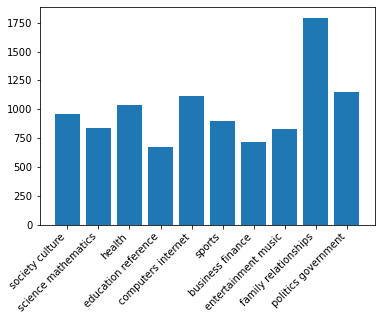

In [460]:
#How predicted categories are distributed?
plt.bar(categories,[[list(y_pred).count(x)][0] for x in set(y_pred)])
plt.xticks(rotation=45, ha='right')
plt.show()

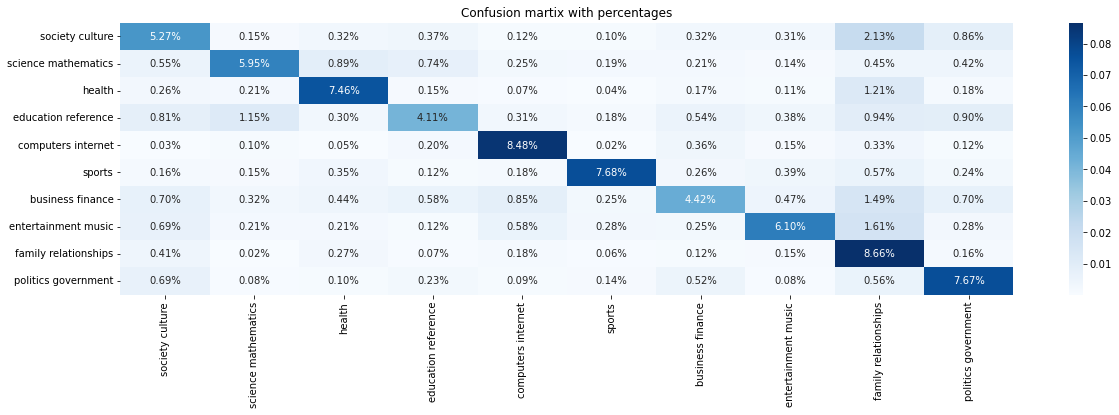

In [437]:
f = plt.figure(figsize=(20,5))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories).set_title("Confusion martix with percentages")
plt.show()

Although the accuracy is far from perfect (69%), it is obvious after analyzing different questions that most of them provide ambibious context or they are just too short. Examples:

'is every girl the only girl  if i am not near the girl i love do i love the girl i am near  will this mean i have to chose every moment  freedom is gone'

The question relates to HEALTH, but I would classify it as a RELATIONSHIP question. 

Another reason of missclaffication: Naive Bayes does not take into account meaning but simply counts important words. This raises problem, when keywords from multiple categories are present. for example jobs and universities in the sentence below

'do u know about any part time jobs  i am a first year student at the university of technology  utech  and i need a job to help pay my school fees  please help me find a job as soon as possibe'

## Explore the missclassidied questions

### Predicted – 'family relationships'. Actual – 'society culture',

In [466]:
n=0
for i in range(len(test_sample)):
    if list(test_sample[0])[i]==1 and y_pred[i]==9 :
        n+=1
        print(list(test_sample["question"])[i],'\n')
        if n==10:
            break

What do you think about Russians?Are you prejudiced when you meet them?  

What should mothers do if their child keeps giving them worms or snakes they find outside?  

How to be a Lady? I am wondering... what are the ettiquettes of being a lady...  I love it when you are at a restaurant and a lady comes in and all the gentlemen stand up. please. if you know of any "lady ettiquettes" like for example: ladies should not say bad words... etc etc etc. it would be really helpfull. THANK YOU ! 

I recently had a talk with god, and he told me to do terrible things!? Should I do them just because he is the all-powerful one? 

What should a fat woman do if a person opens the door when she's on the toilet?  

Is it appropriate to kiss on the 1st date?  

what do baptisms do?  

Christmas presents? okay, there are tons of things guys can get for girls for X-mas. you know, jewelry, candy, flowers, stuffed animals, ANYTHING. but what kind of stuff do girls get for guys?? 

Homosexuality to heteros

### Predicted – 'family relationships'.  Actual –  'entertainment music'

In [469]:
n=0
for i in range(len(test_sample)):
    if list(test_sample[0])[i]==8 and y_pred[i]==9 :
        n+=1
        print(list(test_sample["question"])[i],'\n')
        if n==10:
            break

anyone!!?!!??!?!?!!?!? hey if there is anyone out there that likes metal, that worships dimebag darrell, that thinks that zakk wylde is the best, you need to add me to your friends list on IM. I am bored. and i like to talk music to people. 

Have anyone done a prank on you? If so, what have they done?\nIf you done something, what have you done to them?\n\n\nThey dumped water all over me and I did it back. And of course I did some phone pranks (who hasn't? lol) 

Scenes from a  hat, What do you say to your dog you could never say to your husband or wife? From Who's line is it anyway 

Do you want him as your lap-dog? http://static.flickr.com/113/288712560_1fa7718a6b_o.jpg <----He is soo cute 

Alien love? A pair of newly weds win a trip to mars....\nIn the hotel bar they meet an alien couple who suggest a partner swap...\nThey decide to go for it!\nThe woman takes her alien to bed, and he when he pats his head, his willy gets longer...\nAs he rubs his tummy, his willy gets wider and ha

### Predicted – 'science mathematics'. Actual – 'education reference'

In [471]:
n=0
for i in range(len(test_sample)):
    if list(test_sample[0])[i]==4 and y_pred[i]==2 :
        n+=1
        print(list(test_sample["question"])[i],'\n')
        if n==10:
            break

What are the factors causing inflation?  

do you know something about physics experiment?about "BEDS OF NAIL"? how to explain that experiment? 

What is the most common metal in the human body?  ;P?  

what is the square root of 28?  

convert 905(base10) to its octal equivalent?  

how many amps can kill a human?  

How much energy does it take to melt a 16.87g icecube? My choices are 102 kj, 108 kj, 936 J, 5.64 kj 

non chromosomal genetic element?  

What is the difference between ideal gases and real gases?  

What cdan you do to slow the rate of global warming?  

